In [619]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date

import statsmodels.api as sm

In [343]:
def get_time_diff(column1, column2):
    
    Format = '%d %H:%M:%S'
    col1 = []
    col2 = []
    for a,b in zip(column1, column2):
        col1.append(datetime.strptime(a,Format))
        col2.append(datetime.strptime(b,Format))
        
    time_diff = [b-a for a,b in zip(col1,col2)]
    return time_diff

In [771]:
def import_data():
    df = pd.read_excel('MOS_Assignment_Case_Study.xlsx')
    df.drop(['Unnamed: 13','Unnamed: 14','Unnamed: 15','Unnamed: 16'],axis=1,inplace = True)
    df['date'] = '2020-05-'+df['Customer placed order datetime'].apply(lambda x: x.split(' ')[0])
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].apply(lambda x: x.weekday())
    
    df.dropna(subset=['Placed order with restaurant datetime'],axis= 0,inplace=True)
    
    df['Cust_Rest_order_diff'] = get_time_diff(df['Customer placed order datetime'],df['Placed order with restaurant datetime'])
    df['Cust_Rest_order_diff'] =df['Cust_Rest_order_diff'].apply(lambda x: x.seconds/60)
    
    df['Total_delivery_time'] = get_time_diff(df['Customer placed order datetime'],df['Delivered to consumer datetime'])
    df['Total_delivery_time'] = df['Total_delivery_time'].apply(lambda x: x.seconds/60)
    
    df['Rest_to_cust_time'] = df['Total_delivery_time'] - df['Cust_Rest_order_diff']
    
    df['Customer placed order datetime'] = df['Customer placed order datetime'].apply(lambda x: x.split(' ')[1])
    df['Customer placed order datetime'] = pd.to_datetime(df['Customer placed order datetime'], format='%H:%M:%S').dt.time
    
    df['Placed order with restaurant datetime'] = pd.to_datetime(df['Placed order with restaurant datetime'],format = '%d %H:%M:%S').dt.time
    
    df['Driver at restaurant datetime']= pd.to_datetime(df['Driver at restaurant datetime'],format = '%d %H:%M:%S').dt.time
    
    df['Delivered to consumer datetime']= pd.to_datetime(df['Delivered to consumer datetime'],format = '%d %H:%M:%S').dt.time
    
    
    df['revenue'] = df['Order total'] - df['Amount of discount'] - df['Refunded amount']
    
    df = df[['date','day_of_week','Hour',
             'Customer placed order datetime',
             'Placed order with restaurant datetime',
             'Driver at restaurant datetime', 'Delivered to consumer datetime',
             'Cust_Rest_order_diff','Rest_to_cust_time','Total_delivery_time',
             'Driver ID', 'Restaurant ID', 'Consumer ID', 
             'Delivery Region','Is ASAP', 
             'Order total', 'Amount of discount', 'Amount of tip','Refunded amount','revenue']]
    
    df.reset_index(drop=True,inplace=True)
    print('data has been imported')
    
    return df

In [337]:
# For R score, lower the score the more valuable the customer is 
def RScore(R,re,q):
    if R <= q[re][0.25]:
        return 4
    elif R <= q[re][0.50]:
        return 3
    elif R <= q[re][0.75]: 
        return 2
    else:
        return 1

# For F&M score, higher the score the more valuable the customer is    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [772]:
df = import_data()

data has been imported


#### Q1) Which city did the most orders in our data set and how many orders did they complete?

In [66]:
city_order = df.groupby('Delivery Region')['Order total'].agg(['count','sum']).sort_values(by='sum',ascending=False)
city_order.columns = ['Orders count', 'Orders sum']

city_order

,Orders count,Orders sum
Delivery Region,,
Palo Alto,11433,600034.18
Mountain View,3760,195792.37
San Jose,2859,125045.32
None,26,5833.46


#### Q2) Which city did the most ASAP orders in our data set and how many did they complete?

In [67]:
df_asap = df[df['Is ASAP']==True]
city_order_asap = df_asap.groupby('Delivery Region')['Order total'].agg(['count','sum']).sort_values(by='sum',
                                                                                                     ascending=False)
city_order_asap.columns = ['ASAP orders count', 'Orders sum']

city_order_asap

,ASAP orders count,Orders sum
Delivery Region,,
Palo Alto,8877,389505.24
Mountain View,3067,138982.81
San Jose,2491,106185.99


#### Q3) Create a line graph showing order volume by hour of day (customer placed order)?

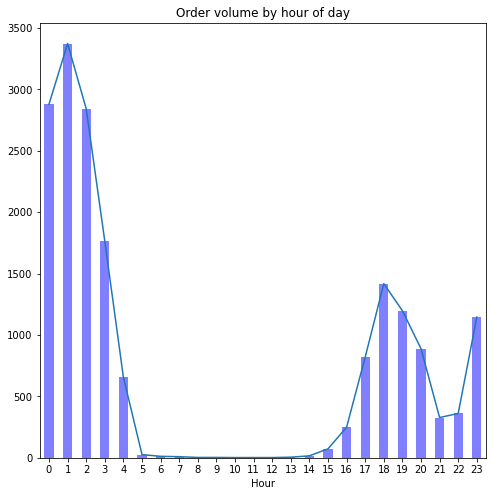

In [81]:
order_by_hour = df.groupby('Hour')['Customer placed order datetime'].count()

figure,ax = plt.subplots(figsize=(8,8))
sns.lineplot(order_by_hour.index,order_by_hour.values,markers=True,ax=ax)
df.groupby('Hour')['Customer placed order datetime'].count().plot(kind='bar',color='blue',alpha=0.5,ax=ax,legend=False)
plt.title('Order volume by hour of day')
plt.xticks(np.arange(0,24),rotation=360)
plt.savefig('DoorDash_case_interview_Q3.png')

#### Q4 3 Analyses of the dataset

<b> Loyal customers - RFM Model</b>

In [370]:
# Assume the current date to be 1st June, 2020
current_date = datetime(2020,6,1)

# Compute recency, which is the latest date when customer placed order
customers_R = df.groupby('Consumer ID')['date'].max().reset_index()
customers_R['recency'] =  current_date - customers_R['date']
customers_R['recency'] = customers_R['recency'].apply(lambda x: x.days)

# Compute frequency of order customer has placed 
customers_F = df.groupby('Consumer ID')['Order total'].count().reset_index()

# Compute the total amount of money each customer spent
customers_M = df.groupby('Consumer ID')['Customer placed order datetime'].max()
customers_M = df.groupby('Consumer ID')['Order total','Amount of discount'].sum().reset_index()
customers_M['monetary'] = customers_M['Order total'] - customers_M['Amount of discount']

# Group all the above dateset 
df_customers = pd.concat([
    customers_R[['Consumer ID','recency']],
    customers_F['Order total'],
    customers_M['monetary']],
    axis=1)

# Compute the RFM score
RFM_Quantile = df_customers.iloc[:,1:].quantile([.25,.5,.75]).to_dict()

df_customers['R_score'] = df_customers['recency'].apply(lambda x: RScore(x,'recency',Quantile))
df_customers['F_score'] = df_customers['Order total'].apply(lambda x: FMScore(x,'Order total',Quantile))
df_customers['M_score'] = df_customers['monetary'].apply(lambda x: FMScore(x,'monetary',Quantile))
df_customers['RFM_score'] = df_customers['R_score'].map(str)+\
                            df_customers['F_score'].map(str)+\
                            df_customers['M_score'].map(str)

# For demonstration purpose, only the most valuable customers are selected to brief analysis
loyal_customers = pd.DataFrame(df_customers[df_customers['RFM_score']=='444']['Consumer ID'].reset_index(drop=True))

df_loyal_customers = loyal_customers.merge(df,how='left',on='Consumer ID')

C:\Anaconda\envs\GJ\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # Remove the CWD from sys.path while we load stuff.


In [371]:
print('the top 10 loyal customers with most orders amount and average spending:')
Most_order_customer = df_loyal_customers.groupby('Consumer ID')['Order total'].agg(['count','mean']).sort_values('count',ascending=False).head(10)
Most_order_customer

the top 10 loyal customers with most orders amount and average spending:


,count,mean
Consumer ID,,
929,50,199.328200
11956,46,30.759130
2469,43,38.237907
4087,39,61.560256
22183,36,35.466667
8000,35,94.054571
6245,33,104.783636
13018,27,106.506667
14043,27,125.030370


In [372]:
print('the top 10 loyal customers wwho gives the highest average amount of tips:')
Most_tips_customer = df_loyal_customers.groupby('Consumer ID',as_index=False)['Amount of tip'].mean().sort_values('Amount of tip',ascending=False).head(10)
Most_tips_customer.reset_index(drop=True,inplace=True)
Most_tips_customer

the top 10 loyal customers wwho gives the highest average amount of tips:


,Consumer ID,Amount of tip
0,6711,22.788333
1,3392,20.406667
2,959,18.826364
3,1011,16.687143
4,1173,15.170000
5,2512,14.780000
6,888,14.220000
7,10294,13.992857
8,91848,13.884444
9,13489,13.567500


In [373]:
print('the top 10 restaurants where the loyal customers like to visit:')
Top_restaurants = df_loyal_customers.groupby('Restaurant ID',as_index=False)['Consumer ID'].count().sort_values('Consumer ID',ascending=False).head(10)
Top_restaurants.reset_index(drop=True,inplace=True)
Top_restaurants.columns =['Restaurant ID','Frequency']
Top_restaurants

the top 10 restaurants where the loyal customers like to visit:


,Restaurant ID,Frequency
0,8,348
1,9,291
2,20,215
3,12,195
4,107,190
5,63,172
6,68,159
7,10,134
8,83,112
9,43,110


<b> The cuase of refund </b>

In [685]:
# Select the orders with refund requests
refunded_order = df[df['Refunded amount']>0]
refunded_order.reset_index(drop=True,inplace=True)

Text(0.5, 1.0, 'distribution of refunded amount')

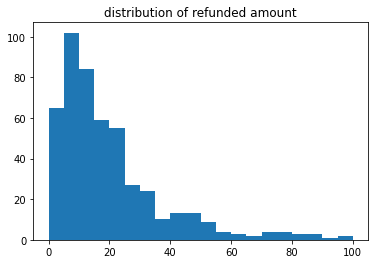

In [811]:
plt.hist(refunded_order['Refunded amount'],bins=20,range=(0,100))
plt.title('distribution of refunded amount')

In [687]:
print('Top 10 Restaurant with most refund in descending order by total amount')
Restaurant_refund = refunded_order.groupby('Restaurant ID')['Refunded amount'].agg(['count','sum']).reset_index()
Restaurant_refund.sort_values(by='sum',ascending=False).head(10)

Top 10 Restaurant with most refund in descending order by total amount


,Restaurant ID,count,sum
13,20,36,822.27
37,63,10,757.88
65,107,24,533.82
5,8,20,418.13
6,9,24,326.33
50,83,10,296.18
28,47,4,252.99
40,68,8,179.59
45,76,5,171.59
1,3,7,154.10


In [688]:
print('The order with highest refund')
idx = refunded_order[['Refunded amount']].idxmax()
refunded_order.iloc[idx,:].T

The order with highest refund


,163
date,2020-05-30 00:00:00
day_of_week,5
Hour,17
Customer placed order datetime,17:10:40
Placed order with restaurant datetime,17:53:58
Driver at restaurant datetime,18:45:32
Delivered to consumer datetime,19:32:26
Cust_Rest_order_diff,43.3
Rest_to_cust_time,98.4667
Total_delivery_time,141.767


In [ ]:
#refunded_order['Total_delivery_time'] = refunded_order['Total_delivery_time'].apply(lambda x: round(x/60,1))
refunded_order['Total_delivery_time'] = refunded_order['Total_delivery_time'].apply(lambda x: round(x*60,1))
refunded_count_by_hour = pd.DataFrame(refunded_order.groupby('Total_delivery_time')['Refunded amount'].count())

plt.figure()
refunded_count_by_hour.plot(kind='bar',figsize=(15,5))
plt.title('Distribution of number of refund per total delivery time in hour')
plt.xlabel('total delivery time (hour)')
plt.xticks(rotation=45)
plt.ylabel('number of refund')

In [817]:
print('Top 10 restaurants with highest count of refund')
refund_by_rest_mean = pd.DataFrame(refunded_order.groupby('Restaurant ID',as_index=False)['Cust_Rest_order_diff'].mean())
refund_by_rest_mean.rename(columns={'Cust_Rest_order_diff':'Cust_Rest_order_diff_mean'},inplace=True)

refund_by_rest_count = pd.DataFrame(refunded_order.groupby('Restaurant ID',as_index=False)['Cust_Rest_order_diff'].count())
refund_by_rest_count.rename(columns={'Cust_Rest_order_diff':'Refund_count'},inplace=True)

refund_by_rest_to_cust = pd.DataFrame(refunded_order.groupby('Restaurant ID',as_index=False)['Rest_to_cust_time'].mean())
refund_by_rest_to_cust.rename(columns={'Rest_to_cust_time':'Rest_to_cust_time_mean'},inplace=True)

driver_arrive_time_na = pd.DataFrame(refunded_order[refunded_order['Driver at restaurant datetime'].isna()].groupby('Restaurant ID',as_index=False)['Refunded amount'].count())
driver_arrive_time_na.rename(columns={'Refunded amount':'missing_driver_arrival_time_count'},inplace=True)

refund_by_rest = pd.merge(refund_by_rest_mean,refund_by_rest_to_cust, on='Restaurant ID')
refund_by_rest = refund_by_rest.merge(driver_arrive_time_na, on='Restaurant ID')

refund_by_rest = refund_by_rest.merge(refund_by_rest_count, on='Restaurant ID')

refund_by_rest.sort_values(by='Refund_count',ascending=False).head(10)



Top 10 restaurants with highest count of refund


,Restaurant ID,Cust_Rest_order_diff_mean,Rest_to_cust_time_mean,missing_driver_arrival_time_count,Refund_count
8,20,12.915741,56.462500,12,36
30,107,35.736111,61.732639,2,24
5,9,175.364583,67.065278,6,24
4,8,12.801667,71.011667,2,20
21,83,36.475000,49.566667,7,10
7,12,57.464815,33.072222,4,9
18,68,5.747917,54.079167,2,8
42,194,30.593750,32.920833,1,8
1,3,10.230952,56.457143,1,7
13,43,27.064286,49.592857,1,7


Text(0, 0.5, 'time (minute)')

<Figure size 432x288 with 0 Axes>

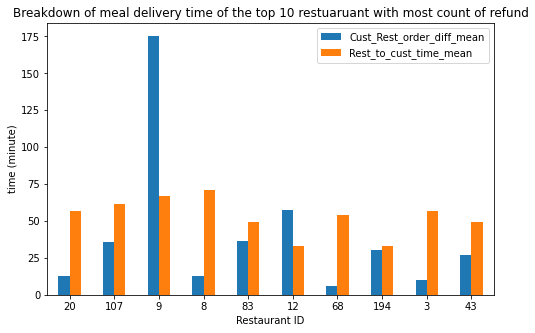

In [713]:
refund_by_rest_top10 = refund_by_rest.sort_values(by='Refund_count',ascending=False).head(10)


plt.figure()
refund_by_rest_top10.set_index('Restaurant ID')[['Cust_Rest_order_diff_mean','Rest_to_cust_time_mean']].plot(kind='bar',figsize=(8,5))
plt.title('Breakdown of meal delivery time of the top 10 restuaruant with most count of refund')
plt.xlabel('Restaurant ID')
plt.xticks(rotation=360)
plt.ylabel('time (minute)')

With this chart, we could see which part of the process that the restaurants are struggling more, allowing us to better identify the defects within the delivery process. For example, restaurant 9 has a higher delay between customer placing order and restuarant placing order. We need to further figure out what is the cause for such high delay

<b> Top dashers </b>

In [805]:
dasher_order_count = pd.DataFrame(df.groupby('Driver ID',as_index=False)['Order total'].count())
dasher_order_count.rename(columns={'Order total':'Order_count'},inplace=True)

dasher_order_rev = pd.DataFrame(df.groupby('Driver ID',as_index=False)['revenue'].agg(['sum','mean']))
dasher_order_rev.rename(columns={'sum':'rev_sum','mean':'rev_average'},inplace=True)

dasher_tips = pd.DataFrame(df.groupby('Driver ID',as_index=False)['Amount of tip'].agg(['sum','mean']))
dasher_tips.rename(columns={'sum':'tip_sum','mean':'tip_average'},inplace=True)

dasher_regions = pd.DataFrame(df.groupby(['Driver ID','Delivery Region'])['Order total'].count())
dasher_regions = dasher_regions.sort_values('Order total',ascending=False).reset_index().drop_duplicates(subset='Driver ID',
                                                                                                        keep='first')

dasher_delivery_time = pd.DataFrame(df.groupby('Driver ID',as_index=False)['Total_delivery_time'].mean())
dasher_delivery_time.rename(columns={'Total_delivery_time':'Total_delivery_time_average'},inplace=True)

dasher_discount = pd.DataFrame(df.groupby('Driver ID',as_index=False)['Amount of discount'].mean())
dasher_discount.rename(columns={'Amount of discount':'discount_average'},inplace=True)

df_dasher = pd.merge(dasher_regions[['Driver ID','Delivery Region']],dasher_order_count, on='Driver ID')
df_dasher = df_dasher.merge(dasher_delivery_time, on='Driver ID')
df_dasher = df_dasher.merge(dasher_order_rev, on='Driver ID')
df_dasher = df_dasher.merge(dasher_discount, on='Driver ID')
df_dasher = df_dasher.merge(dasher_tips, on='Driver ID')

In [806]:
print("Top 10 dashers with most order and highest revenue")
df_dasher.sort_values(['Order_count','rev_average'],ascending=False).head(10)

Top 10 dashers with most order and highest revenue


,Driver ID,Delivery Region,Order_count,Total_delivery_time_average,rev_sum,rev_average,discount_average,tip_sum,tip_average
1,248,Mountain View,316,63.848312,16674.09,52.766108,0.889241,1179.22,3.731709
0,195,Palo Alto,296,77.803660,17031.38,57.538446,1.449932,1188.96,4.016757
2,267,Palo Alto,287,100.368757,14256.94,49.675749,1.510976,1011.21,3.523380
3,222,Palo Alto,262,71.725827,11588.65,44.231489,1.868053,809.78,3.090763
4,216,Palo Alto,253,74.874704,13268.96,52.446482,1.024348,922.23,3.645178
5,259,Palo Alto,245,60.358231,11754.10,47.975918,1.674612,811.11,3.310653
26,343,Palo Alto,235,66.836312,12407.38,52.797362,0.990723,852.89,3.629319
7,320,Palo Alto,225,70.535778,10775.66,47.891822,0.853333,735.21,3.267600
6,84,Palo Alto,222,64.679505,11431.32,51.492432,1.151712,785.74,3.539369
8,36,San Jose,216,60.477083,8967.19,41.514769,1.828704,797.02,3.689907


In [818]:
features_dummies = pd.get_dummies(df_dasher['Delivery Region'])

dasher_features = pd.concat([df_dasher[['Order_count','Total_delivery_time_average','discount_average','rev_average']],
                             features_dummies],axis=1)

x = dasher_features
y = df_dasher['tip_average']

model = sm.OLS(y,x) 
 
results = model.fit()

# report the summary of the model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            tip_average   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     67.69
Date:                Tue, 09 Jun 2020   Prob (F-statistic):           3.51e-52
Time:                        11:04:15   Log-Likelihood:                -273.34
No. Observations:                 295   AIC:                             560.7
Df Residuals:                     288   BIC:                             586.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Order_count                    -0.0001      0.001     -0.229      0.819      -0.001       0.001
Total_delivery_time_average     0.0004      0.001      0.270      0.788      -0.002       0.003
discount_average                0.0756      0.012      6.190      0.000       0.052       0.100
rev_average                     0.0682      0.004     17.249      0.000       0.060       0.076
Mountain View                   0.1037      0.190      0.545      0.586      -0.270       0.478
Palo Alto                      -0.0584      0.184     -0.318      0.751      -0.420       0.303
San Jose                        0.6131      0.176      3.487      0.001       0.267       0.959
==============================================================================
Omnibus:                      231.698   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7939.146
Skew:                           2.775   Prob(JB):                         0.00
Kurtosis:                      27.801   Cond. No.                         943.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the liner regression model, San Jose seems to be most positvitely correlated with the amount of tip. In other words, customers live in San Jose looks like more generous than other regions